# Society for Neuroscience Annual Meeting, 2022
# \#8587 Population spike-synchrony contributes to the spectral exponent of aperiodic neural activity
#### M. W. Preston, S. Fei, B. Voytek
## Poster Panel \#3: Decreases in correlated spiking activity recapitulate event-related shifts in the aperiodic exponent

### Set-up

#### Imports

In [18]:
# general imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable

In [19]:
# spike analysis toolboxes

# elephant
# from elephant.conversion import BinnedSpikeTrain
# from elephant.spike_train_correlation import correlation_coefficient, covariance

# elephant reqs
import neo
import quantities as pq


In [20]:
# voytek lab imports
# from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times


In [21]:
# project-specific imports
import sys
sys.path.append('C:/users/micha/projects/sfn_2022//scripts')
# from utils import comp_exp, spiketimes_to_spiketrains, spikes_to_lfp


#### Settings

In [22]:
# directories
PATH = "C:/Users/micha/projects/sfn_2022"
DIR_FIG = PATH + "/figures"
DIR_DATA = PATH + "/data"


In [23]:
# dataset details
FS = 1000 # sampling frequency

# figure appearance
plt.style.use(PATH + '/stylelib/sfn_2022.mplstyle')
COLORS = ["#7570b3", "#1b9e77", "#d95f02"]

#### Functions

In [24]:

def sim_ou_dynamic(n_seconds, fs, mu, sigma, tau):
    ''' 
    Simulate an Ornstein-Uhlenbeck process with dymanic parameters
    
    
    Parameters
    ----------
    n_seconds : float
        Simulation time (s)
    fs : float
        Sampling rate (Hz)
    sigma : float, 1d array (length = n_seconds*fs)
        Standard deviation signal        
    tau : float, 1d array (length = n_seconds*fs)
        Timescale of signal (s)
    mu : float, 1d array (length = n_seconds*fs)
        Mean of signal


    Returns
    signal : 1d array
        Simulated Ornstein-Uhlenbeck process

    References
    ----------
    https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/
    
    '''

    # initialize signal and set first value equal to the mean
    signal = np.zeros(int(np.ceil(n_seconds * fs)))
    signal[0] = mu[0]
    
    # define constants in OU equation (to speed computation) 
    dt = 1 / fs
    sqrtdt = np.sqrt(dt)
    rand = np.random.randn(len(signal))
    
    # simulate OU
    for ii in range(len(signal)-1):
        signal[ii + 1] = signal[ii] + \
                        dt * (-(signal[ii] - mu[ii]) / tau[ii]) + \
                        sigma[ii] * np.sqrt(2/tau[ii]) * sqrtdt * rand[ii]
    
    # define time vector
    time = np.linspace(0, n_seconds, len(signal))
    
    return signal, time



### Main

In [28]:
# create placeholder data

N_SECONDS = 10
FS = 1000 # sampling frequency
N_NEURONS = 1000
MEAN_RATE = 10 # average rate of each neuron (Hz)
ALPHA = 1.
TAU_C = 25 / 1000

# voytek lab imports
from neurodsp.spectral import compute_spectrum

# project-specific imports
import sys
sys.path.append('C:/users/micha/projects/sfn_2022//scripts')
from utils import sim_ou_process,get_spike_times,convolve_psps

def sim_homogeneous_pool(rand_process=None, n_neurons=5, mu=20, variance=300, n_seconds=1, fs=1000,
                         tau_c=0.01):
    """
    *** modied to input white noise process or any random process ***
    
    simulate population spiking of N neurons firing at firing_rate each, return a
    spike trains roster of size (n_seconds*fs by n_neurons)

    Parameters
    ----------
    n_neurons : scalar, optional
        number of neurons in population. The default is 5.
    mu : scalar, optional
        mean of random walk. The default is 20.
    sigma : scalar, optional
        std of random walk. The default is 300.
    n_seconds : scalar, optional
        duration of signal (s). The default is 1.
    fs : scalar, optional
        sampling frequency (Hz). The default is 1000.
    tau : scalar, optional
        timescale (sec). The default is 0.01.

    Returns
    -------
    spikes : 2D array
        spike trains.
    rand_process : 1D array
        instantanious firing rate.

    """

    if rand_process is None:
        # simulate randon process (Ornstein-Uhlenbeck)
        rand_process, _ = sim_ou_process(n_seconds, fs, mu=mu, sigma=variance**0.5, tau=tau_c)
        # rand_process[rand_process < 0] = 0 # ensure all positive values

    # generate spikes from OU process
    spikes = np.zeros([n_neurons, len(rand_process)])

    # turn rates into spikes
    for j_bin in range(len(rand_process)):
        for i_neuron in range(n_neurons):
            if rand_process[j_bin] / fs > np.random.uniform():
                spikes[i_neuron, j_bin] = 1
    
    return spikes, rand_process

def run_homogeneouspool_sim(sync=True):
    # imports
    from scipy.signal import detrend

    # simulate spiking
    if sync:
        # simulate synchronized spiking
        spikes, rand_process = sim_homogeneous_pool(n_neurons=N_NEURONS, mu=MEAN_RATE, variance=MEAN_RATE**2, n_seconds=10, fs=FS, tau_c=TAU_C)
    
    else:
        # simulate desynchronized spiking
        rand_white = np.random.normal(loc=MEAN_RATE, scale=MEAN_RATE**0.5, size=N_SECONDS*FS)
        spikes, _ = sim_homogeneous_pool(rand_process=rand_white, n_neurons=N_NEURONS, n_seconds=N_SECONDS, fs=FS)

    # get spike times
    time = np.linspace(0,N_SECONDS,spikes.shape[1])
    spike_times = []
    for i_cell in range(len(spikes)):
        spike_times.append(get_spike_times(spikes[i_cell], time))

    # simulate LFP
    pop_spikes = np.sum(spikes, axis=0)
    lfp = convolve_psps(pop_spikes, FS)
    lfp = detrend(lfp, type='constant')
    freq, spectra = compute_spectrum(lfp, FS, f_range=[2,200])
    
    return spike_times, lfp, spectra, freq

spike_times, lfp, spectra, freq = run_homogeneouspool_sim(sync=True)


In [30]:
# elephant
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient

In [31]:
# compute correlation/covarience measures

# inti
n_neurons = len(spike_times)
corr_mat = []
spike_trains = []

st = spike_times
for i_unit in range(len(st)):
    # skip units withou spikes
    if np.ndim(st[i_unit]) == 0: continue
    if len(st[i_unit]) == 0: continue
    # create spike train
    st_i = neo.SpikeTrain(st[i_unit]*pq.s, N_SECONDS*pq.s)
    spike_trains.append(st_i)

# compute corr
corr_mat = correlation_coefficient(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))

# compute norm for colorbar
limit = np.max(np.abs(corr_mat))*0.1
norm = TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)



In [32]:
time2plot = 10
time = create_times(time2plot, FS)
freq_post = freq
spectra_post = spectra
freq_pre = freq
spectra_pre = spectra

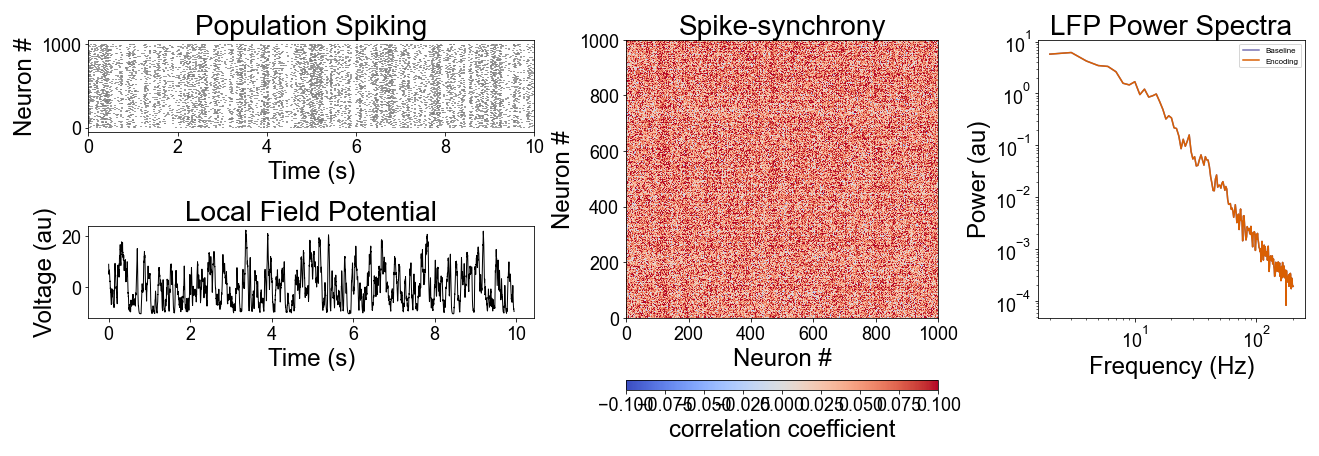

In [34]:
# create figure

# settings
time2plot = 10 # plot <time2plot> seconds only

# create figure and axes
fig = plt.figure(figsize=[18,6])

# set up gridspec
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, 
    width_ratios=[2,1.4,1.2], height_ratios=[1,1,0.1])
ax_spikes = fig.add_subplot(spec[0,0])
ax_lfp = fig.add_subplot(spec[1,0])
ax_corr = fig.add_subplot(spec[:2,1])
ax_psd = fig.add_subplot(spec[:2,2])
ax_cb = fig.add_subplot(spec[2,1])

# plot spikes
ax_spikes.eventplot(spike_times, color='grey')
ax_spikes.set_xlim([0,time2plot])
ax_spikes.set(xlabel='Time (s)', ylabel='Neuron #')

# plot LFP
field = lfp[:time2plot*FS]
ax_lfp.plot(time[:len(field)], field, linewidth=1, color='k')
ax_lfp.set(xlabel='Time (s)', ylabel='Voltage (au)')

# plot corr
ax_corr.pcolormesh(corr_mat, cmap='coolwarm', norm=norm)
fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax_corr, cax=ax_cb,
    orientation='horizontal', label='correlation coefficient')
ax_corr.set(xlabel='Neuron #',ylabel='Neuron #')
# ax_corr.set_title('Upper: White-noise \nLower: Natural-scene')
ax_corr.set_title('Spike-synchrony')

# plt PDSs
ax_psd.loglog(freq_pre, spectra_pre, label='Baseline', color=COLORS[0])
ax_psd.loglog(freq_post, spectra_post, label='Encoding', color=COLORS[2])
ax_psd.legend(fontsize=8)
ax_psd.set(xlabel='Frequency (Hz)', ylabel='Power (au)')

# set titles
ax_spikes.set_title('Population Spiking')
ax_lfp.set_title('Local Field Potential')
ax_corr.set_title('Spike-synchrony')
ax_psd.set_title('LFP Power Spectra')

# save
plt.savefig(DIR_FIG + f'/panel_3_fig0.png')